<a href="https://colab.research.google.com/github/Danilov-Aleksandr/CV_Korpus/blob/master/%D0%90%D1%83%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8_custom_%D0%B4%D0%B0%D1%82%D0%B0%D0%BB%D0%BE%D0%B0%D0%B4%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача: написать загрузчик данных и проделать с ними аугментации с помощью библиотеки Pytorch. Так же знакомство с библиотекой Albumentations**

---

In [ ]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
from PIL import Image

import albumentations
from albumentations import pytorch as AT



%matplotlib inline

## Загружаем и подготавливаем данные

Пример подготовки данных для обучения нейронной сети на Pytorch. Данные разбиваются на три части:

train (данные для обучения)
val (данные для проверки)
test (данные для тестирования)

По-умолчанию для обучения используется 70% изображений, для проверки - 15%, для тестрования также 15%.

Перед запуском необходимо добавить к себе на диск файл dogs-vs-cats.zip с набором изображений кошек и собак Dogs vs. Cats.

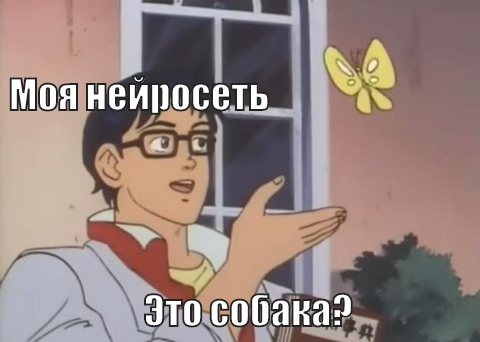

In [ ]:
# !cp '/content/drive/My Drive/Программа по ML v2/Домашка и материалы/7. Даталоадер + аугментации. Немного о кэгл./dogs-vs-cats.zip' /content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Распаковка датасета
# with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/My Drive/dogs-vs-cats.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')
  
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

with zipfile.ZipFile('/content/test1.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

In [ ]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [ ]:
val_files = train_files[:2500]

In [ ]:
print(len(train_files), len(test_files))

25000 12500


Самое время заняться классом Dataset:

In [ ]:
class CatDogDataset(Dataset):

    def __init__(self, file_list, dir, transform=None, mode='train'):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform = transform
        self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    #метод который позволяет нам индексировать датасет
    def __getitem__(self, idx):
        #считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_list[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.mode == 'train':
            if 'dog' in self.file_list[idx]:
                self.label = 1
            else:
                self.label = 0

        #применяем аугментации
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        if self.mode == 'train':
            return image, self.label
        else:
            return image



In [ ]:
#зададим немного гиперпараметров
batch_size = 32
num_workers = -1
img_size = 256

Тут можно поиграть с альбументациями: https://albumentations.ai/

In [ ]:
#Пример того как выглядит обычно набор аугментаций. 
#В зависимости от задачи может отличаться количеством и сложностью.

data_transforms = albumentations.Compose([
    #albumentations.RandomCrop(int(img_size*1.08)), 
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

#обычно аугментации для трейн и тест датасетов разделают. 
#На тесте обычно не нужно сильно изменять изображения
data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

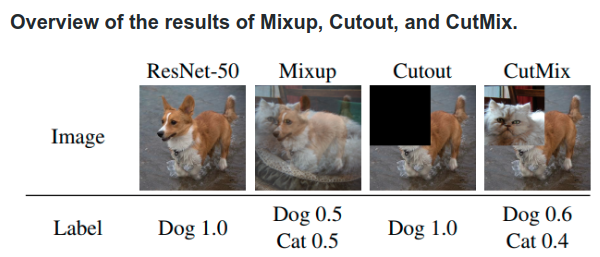

In [ ]:
#Инициализируем датасеты
trainset = CatDogDataset(train_files, train_dir, transform = data_transforms)
testset = CatDogDataset(test_files, test_dir, 
                        transform=data_transforms_test, mode = "test")

In [ ]:
#Разделим трейновую часть на трейн и валидацию.

valid_size = int(len(train_files) * 0.15) #размер валидационной части (10-15%)
indices = torch.randperm(len(trainset)) #создадим лист индексов
#определим подвыборки для трейн и валидации
train_indices = indices[:len(indices)-valid_size] 
valid_indices = indices[len(indices)-valid_size:] 



#создаем даталоадеры для всех 3х подвыборок.
trainloader = torch.utils.data.DataLoader(trainset, pin_memory=True, 
                                        batch_size=batch_size,
                                        sampler=SubsetRandomSampler(train_indices))
validloader = torch.utils.data.DataLoader(trainset, pin_memory=True, 
                                        batch_size=batch_size,
                                        sampler=SubsetRandomSampler(valid_indices))

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         num_workers = num_workers)

ValueError: ignored

In [ ]:
torch.__version__

'1.6.0+cu101'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


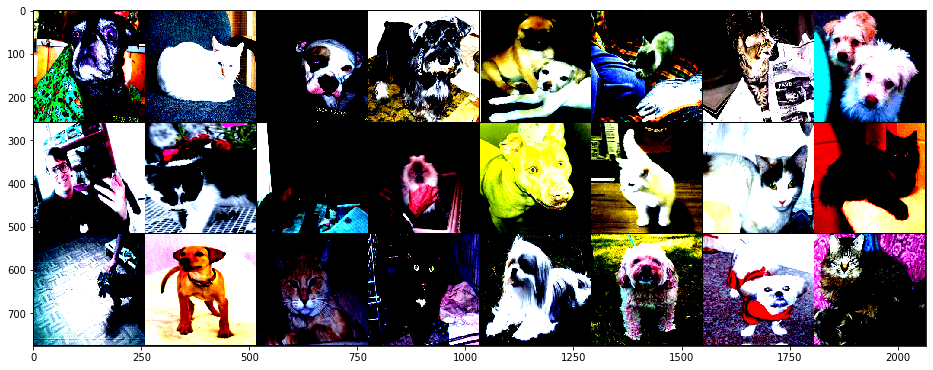

In [ ]:
#Проверим работоспособность
samples, labels = next(iter(validloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')

На следующем занятии:

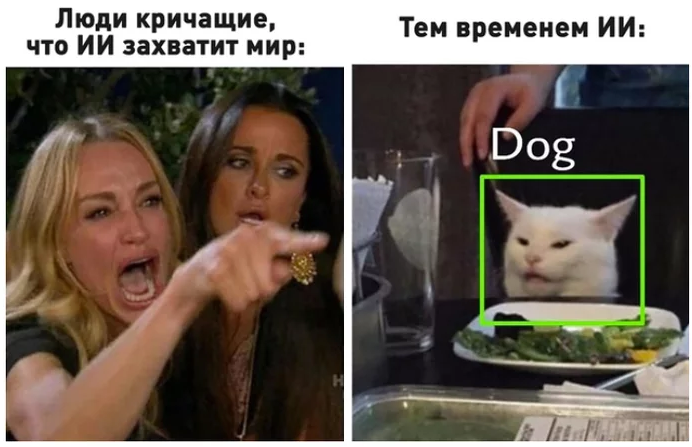